In [136]:
from IPython.utils import io
import multiprocessing
from matplotlib import pyplot
import numpy
import pygmo

# Sets random number generator
numpy.random.seed(1234)

# imports from the pyfoomb package
import pyfoomb
print(f'Current package version of {pyfoomb.__name__}: {pyfoomb.__version__}')

from pyfoomb import BioprocessModel
from pyfoomb import Caretaker
from pyfoomb import Visualization
from pyfoomb import TimeSeries
from pyfoomb import Helpers

from pyfoomb.simulation import CVodeError

Current package version of pyfoomb: 2.17.7


In [137]:
# Defines the model class
class YeastFedBatch(BioprocessModel):
    
    def rhs(self, t, y, sw):
        # Unpacks the state vector. The states are alphabetically ordered.
        A, B, E, G, N, V = y
        
        # Unpacks the model parameters.
        k1 = self.model_parameters['k1']
        k2 = self.model_parameters['k2']
        k3 = self.model_parameters['k3']
        k4 = self.model_parameters['k4']
        k5 = self.model_parameters['k5']
        k6 = self.model_parameters['k6']
        mu_Omax = self.model_parameters['mu_Omax']
        mu_Gmax = self.model_parameters['mu_Gmax']
        mu_Nmax = self.model_parameters['mu_Nmax']
        k_G = self.model_parameters['k_G']
        k_l = self.model_parameters['k_l']
        k_N = self.model_parameters['k_N']
        k_A = self.model_parameters['k_A']
        k_lA = self.model_parameters['k_lA']
        k_lA2 = self.model_parameters['k_lA2']
        k_E = self.model_parameters['k_E']
        cSF1 = self.model_parameters['cSF1']
        cSF2 = self.model_parameters['cSF2']
        mu_set1 = self.model_parameters['mu_set1']
        mu_set2 = self.model_parameters['mu_set2']
        tF = self.model_parameters['tF']
        
         # For calculation of F, these two initial values are needed
        G0 = self.initial_values['G0']
        N0 = self.initial_values['G0']
        V0 = self.initial_values['V0']
        
         # Calculate the feeding profile, conditional to the corresponding events
        if sw[1] and not sw[0]:
            F1 = (G0*V0*mu_set1) / (cSF1-G) * numpy.exp(mu_set1*(t-tF))
            F2 = (N0*V0*mu_set2) / (cSF2-N) * numpy.exp(mu_set2*(t-tF))
        else:
            F1 = 0.0
            F2 = 0.0
        
        #The kinetic models associated with the global oxygen consumption rO, the global glucose consumption rG and 
        # the global nitrogen consumption rN
        
        rO = (mu_Omax * k1)/(E+k1)
        rG = (mu_Gmax * G* k_lA)/(G+k_G*A*B +k_lA)
        rN = (mu_Nmax * N*A*B*k_lA2)/(N+k_N*(A*B)+k_A*(A*B)+k_lA2)
        r_3bis=(rO-rG)*E/(E+k_E)
        
        # Rates calculation
        
        r_1 = min(rG,rO)
        r_2 = max(0,rG-rO)
        r_3 = max(0,r_3bis)
        r_4 = rN
        
        # Defines the derivatives.
        
        dAdt = k5*r_2-r_4-A*(k1*r_1 + k2*r_2+k3*r_3+k6*r_4)
        dBdt = k1*r_1*B+k2*r_2*B+k3*r_3*B+k6*r_4*B-((F1 + F2)/V)*B
        dEdt = k2*r_2*B-r_3*B -((F1+F2)/V)*E
        dGdt = -r_1*B-r_2*B +(F1/V)*cSF1 -((F1+F2)/V)*G
        dNdt = -r_4*B +(F2/V)*cSF2 -((F1+F2)/V)*N
        dVdt = F1 + F2
        
        # Returns the derivative as list (or numpy array).
        # The order corresponds to the state vector.
        
        return [dAdt, dBdt, dEdt, dGdt, dNdt, dVdt]
    
    def state_events(self, t, y, sw):
        
        A, B, E, G, N, V = y
        VL_max = self.model_parameters['VL_max']
        # The event is hit, when this expression evaluates to zero
        event_VL_max = V - VL_max
        
        tF = self.model_parameters['tF']
        # The event is hit, when this expression evaluates to zero
        event_tF = t - tF
        return [event_VL_max, event_tF]
    
# Defines a dictionary for the initial values.
# The keys corresponds to the model states, extended by a 0 (zero).
initial_values = {
        'A0' : 0.0,
        'B0' : 0.1,
        'E0' : 0.1,
        'G0' : 0.5,
        'N0' : 0.1,
        'V0' : 1.0,
}

# Defines a dictionary for the model parameters
# The keys match those variable names used in the model class
model_parameters = {
        'k1': 0.5998,
        'k2': 0.0662,
        'k3': 0.9386, 
        'k4': 0.2452,  
        'k5': 0.2389, 
        'k6': 1.015,
        'mu_Omax': 0.4445,
        'mu_Gmax': 2.5364,  
        'mu_Nmax': 1.1903,  
        'k_G': 0.1524, 
        'k_l': 3.1817, 
        'k_N': 2.9370,  
        'k_A': 9.0014,
        'k_lA': 5.5981, 
        'k_lA2': 5.7737,
        'k_E' : 0.1,
        'cSF1' : 0.5,
        'cSF2' : 0.5,
        'mu_set1' : 0.015,
        'mu_set2' : 0.015,
        'tF' : 2.0,
        'VL_max' : 25,
} 

In [138]:
# Instantiate a Caretaker, which manages the model and its parametrization.
caretaker = Caretaker(
    bioprocess_model_class=YeastFedBatch, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

In [139]:
# Runs a forward simulation.
simulation = caretaker.simulate(t=15)

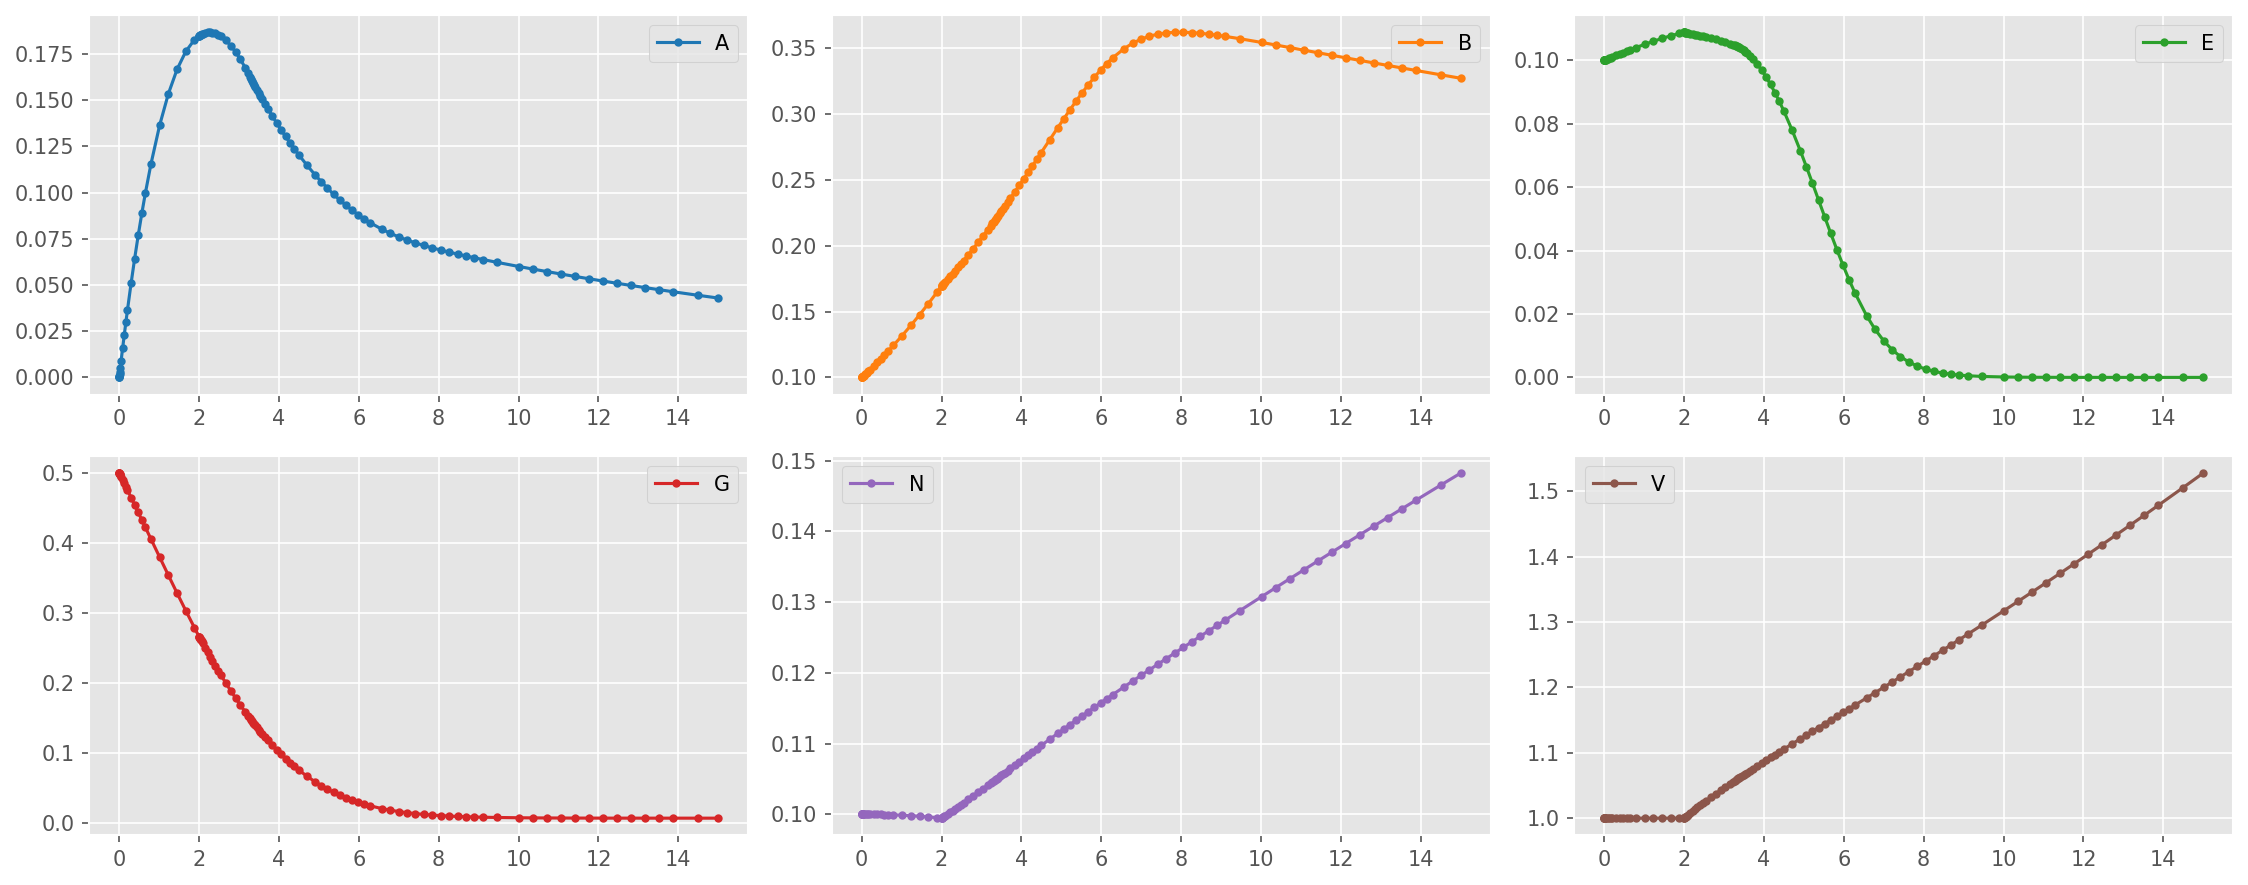

In [140]:
# Visualize the resulting trajectories
_ = Visualization.show_kinetic_data(simulation)